In [ ]:
# Project Introduction

# Prediction optimization is a fascinating subject, and 'boosting' is one of the keywords to know.
# Boosting is an ensemble method that aims to create numerous 'weak learners', or unprecise models, then take the prediction of
# each weak learner into consideration when making a final prediction.

# Boosting is a very common technique for neural networks, but a random forest based boosting method has come to be known as the 
# king of structured data. Enter: XGBoost. The XGBoost algorithm initially creates a decision tree to predict the target. The subsequent
# decision tree then predicts how far off the first tree's prediction will be. The third tree predicts how far off the second decision
# tree's predicted residual will be. This process is continued for however many trees constitute the random forest. An XGBoost model's 
# final  prediction is the sum of all predictions within its random forest: Prediction 1 + how far off prediction 1 should be + how far 
# off tree 2's prediction will be + how far off tree 3's preiction will be + ...

# This project aims to replicate the XGBoost algorithm's structure while using different types of models. My initial prediction will
# be made with a basic multiple regression model, and will be evaluated on adjusted R^2 and RSMPE. I will then predict the regression 
# model's residual with a neural network, add the predicted residual for each observation to the regression model's prediction, and 
# check to see if RMSPE is reduced. Finally, I'll try boosting the regression model's prediction once more with a random forest test. I 
# will be testing this method on a California housing data set, with the target variable being median house price.

In [36]:
# Class imports
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Define data, X, y
data = pd.read_csv('housing.csv')

X = data[['total_rooms', 'population', 'households', 'median_income']]
# Convert 'ocean_proximity' to dummy variable 
# X = pd.get_dummies(X, columns = ['ocean_proximity'])
y = data['median_house_value']


In [37]:
# Create the initial model & print results

X_sm = sm.add_constant(X)
lr = sm.OLS(y, X).fit()
print(lr.summary())
print()
print('RMSPE is : ', np.sqrt(MSE(y, lr.fittedvalues)))

                                 OLS Regression Results                                
Dep. Variable:     median_house_value   R-squared (uncentered):                   0.887
Model:                            OLS   Adj. R-squared (uncentered):              0.887
Method:                 Least Squares   F-statistic:                          4.033e+04
Date:                Mon, 25 Apr 2022   Prob (F-statistic):                        0.00
Time:                        17:21:23   Log-Likelihood:                     -2.6225e+05
No. Observations:               20640   AIC:                                  5.245e+05
Df Residuals:                   20636   BIC:                                  5.245e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [29]:
# The initial model isn't all that bad. 62% of the variation in median house price is explained by total_rooms,
# 'population', 'households', 'median_income', and 'ocean_proximity'. In addition, the p-value of all predictive variables except 
# 'proximity_INLAND' is 0 (or rounds to 0), meaning they are all statistically significant predictors of median house price.

# RMSPE is still about 71,000, however, meaning that the model's predictions of median house value are typically about $71,000 off.
# Lets see if we can improve that through boosting.

In [38]:
# The first boosting model will be a neural network with 2 hidden layers. Dropout will be implimented to avoid overfitting.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

# define the new target variable: how far off the regression model's prediction will be
resid = y - lr.fittedvalues

# Split data into train and test sets to better evaluate performance
X_train, X_test, y_train, y_test = train_test_split(X, resid, test_size=.1, random_state=11111)

# Design & compile the neural network
nn_model = Sequential()
nn_model.add(Dense(4,activation='relu'))
nn_model.add(Dense(4,activation='relu'))
nn_model.add(Dropout(0.2, input_shape=(4,)))
nn_model.add(Dense(4,activation='relu'))
nn_model.add(Dense(1))

# Compile the model, set learning rate, set momentum
nn_model.compile(optimizer='RMSProp',loss='mse')
K.set_value(nn_model.optimizer.learning_rate, 0.01)
K.set_value(nn_model.optimizer.momentum, 0.9)

# train the neural network for 600 epochs
nn_model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=32,epochs=600)


Epoch 1/600
581/581 [==============================] - 1s 1ms/step - loss: 6381589504.0000 - val_loss: 6155874816.0000
Epoch 2/600
581/581 [==============================] - 1s 909us/step - loss: 6336311808.0000 - val_loss: 6078161408.0000
Epoch 3/600
581/581 [==============================] - 1s 896us/step - loss: 6298434560.0000 - val_loss: 6078812672.0000
Epoch 4/600
581/581 [==============================] - 1s 908us/step - loss: 6305044480.0000 - val_loss: 6049534976.0000
Epoch 5/600
581/581 [==============================] - 1s 883us/step - loss: 6311288832.0000 - val_loss: 6043008512.0000
Epoch 6/600
581/581 [==============================] - 1s 885us/step - loss: 6305333248.0000 - val_loss: 6046118912.0000
Epoch 7/600
581/581 [==============================] - 1s 891us/step - loss: 6302297600.0000 - val_loss: 6090648576.0000
Epoch 8/600
581/581 [==============================] - 1s 890us/step - loss: 6309258240.0000 - val_loss: 6069349888.0000
Epoch 9/600
581/581 [=============

In [39]:
# Evaluate the neural network's performance

resid_preds_Xtest = nn_model.predict(X_test)
resid_preds_Xtest
rmspe = np.sqrt(MSE(y_test, resid_preds_Xtest))

print('RMSPE is of the residuals is: ', rmspe)

RMSPE is of the residuals is:  76464.70118568387


In [40]:
# The neural network predicts the how far off the regression model's prediction of median house value will be within $76,000 on average.
# Since the regression model only predicted house price within $79,000 on average, the final prediction should become more accurate
# If the predicted residual is added to it.

print('initial RMSPE: ', np.sqrt(MSE(y, lr.fittedvalues)))
# Update the regression model's predictions based on the predicted residuals
new_preds = lr.fittedvalues + nn_model.predict(X).flatten()    
print('Boosted RMSPE: ', np.sqrt(MSE(y, new_preds)))


initial RMSPE:  79771.77248719876
Boosted RMSPE:  78136.59969586696


In [41]:
# Using a neural network to predict the residual made the model more accurate, decreasing RMSPE by about $1,500.
# In other words, the final prediction got $1,500 more accurate on average.
# Maybe adding a random forest test to predict the residual of the adjusted prediction will further optimize the model.
from sklearn.ensemble import RandomForestRegressor

# Define new target: how far off the adjusted prediction will be
resid_resid = y - new_preds
X_train, X_test, y_train, y_test = train_test_split(X, resid_resid, test_size=.15, random_state=11111)

# Fit the random forest model
rf_model = RandomForestRegressor(n_estimators=65)
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_resid_preds_Xtest = rf_model.predict(X_test)
rmspe = np.sqrt(MSE(y_test, rf_resid_preds_Xtest))
print("RMSPE when predicting the adjusted prediction's residual is: ", rmspe)

RMSPE when predicting the adjusted prediction's residual is:  70127.75168169901


In [42]:
# The random forest predicts the how far off the adjusted prediction of median house value will be within $70,000 on average.
# Since the adjusted prediction of house price was only within $78,000 on average, the adjusted prediction should become more accurate
# If it is adjusted once more by the random forest's predicted residual.

print('initial RMSPE: ', np.sqrt(MSE(y, lr.fittedvalues)))
# Update the regression model's predictions based on the predicted residuals
new_preds = lr.fittedvalues + nn_model.predict(X).flatten()    
print('Single Boosted RMSPE: ', np.sqrt(MSE(y, new_preds)))
# Update the adjusted prediction with it's predicted residual, calculated with the random forest
new_new_preds = new_preds + rf_model.predict(X)
print('Double Boosted RMSPE: ', np.sqrt(MSE(y, new_new_preds)))

initial RMSPE:  79771.77248719876
Single Boosted RMSPE:  78136.59969586696
Double Boosted RMSPE:  37138.34933671247


<BarContainer object of 4 artists>

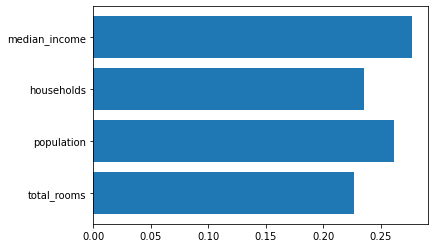

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

features = list(X.columns)
importances = rf_model.feature_importances_

plt.barh(features, importances)

In [ ]:
# Based on the plot above, median_income and population are the most important variables when predicting how far off the model's prediction
# will be

In [43]:
# I am satisfied with this project for 2 main reasons: The error of the final prediction was reduced after both boosting rounds, and
# the error of the final prediction after being boosted by both the neural network and random forest test was less than half of the 
# plain, unboosted regression model's error.

initial_rmspe = np.sqrt(MSE(y, lr.fittedvalues))
double_boosted_rmspe = np.sqrt(MSE(y, new_new_preds))
print("Boosting the regression model's predictions with a neural network and random forest test decreased error by: ")
print(((initial_rmspe - double_boosted_rmspe)/initial_rmspe)*100, '%')

Boosting the regression model's predictions with a neural network and random forest test decreased error by: 
53.4442470327807 %
